In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math


/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

In [4]:
from common import EEG_fif
from common import create_dataloader

In [10]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
#runs = [3,5,7]
subjects = [i for i in range(6,7)]
#subjects = [1]
#runs = [6,10,14]
print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter



raw=raw.notch_filter(np.arange(50, 125, 50))

print("Filter done")
#raw=eeg.raw_ica()

raw=raw.filter( 7,30, method='fir', verbose=20)



/home/nutapolt/eeg_mi/common.py:470: RuntimeWarning: This filename (S006/S006R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:470: RuntimeWarning: This filename (S006/S006R04.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:470: RuntimeWarning: This filename (S006/S006R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fi

Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filter done
Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


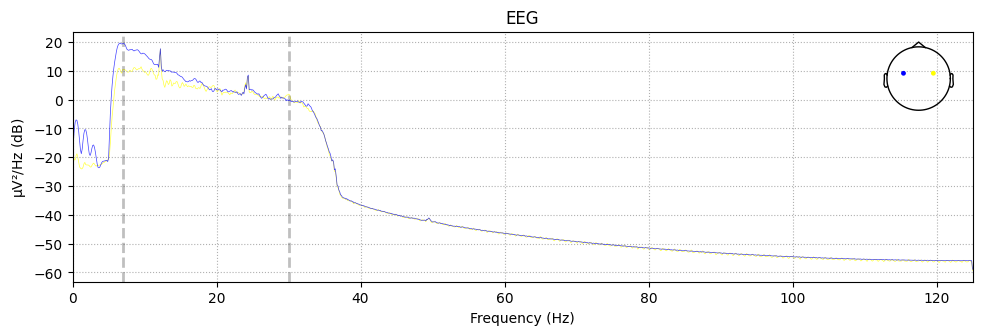

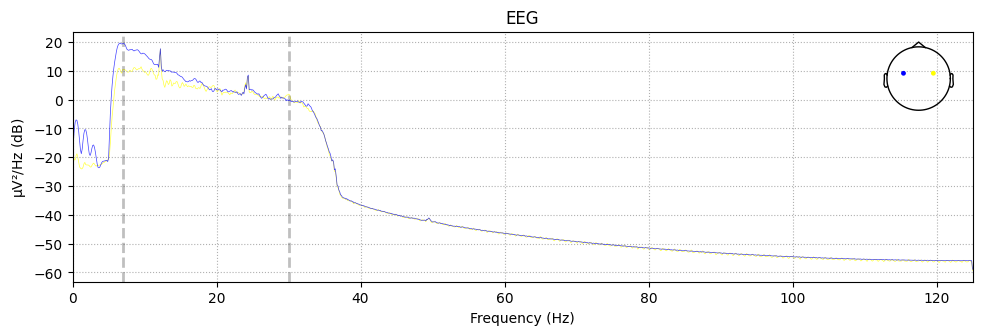

In [11]:
eeg.raw.plot_psd()

In [13]:
epochs=eeg.epochs_visu(raw,tmin=-2)

360 events found
Event IDs: [1 2 4]
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 1501 original time points ...
6 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:500: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [15]:
#X = X[:, :,np.newaxis,:]
X, y = eeg.get_X_y(epochs)
print(X.shape)
y=y-1
y

(174, 2, 1501)


array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train size (121, 2, 1501) (121,)
Test size (53, 2, 1501) (53,)


In [17]:
y_test

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1])

In [18]:

batch_size = 32

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

In [25]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(2, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(192128, 2)
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [26]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [35]:

wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"OurData_CNN_2ch_2class_NEW_EXS6", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0000001,
      "architecture": "CNN",
      "dataset": "NEW_",
      "epochs": 500000,
      "weightname":"OurData_S004_CNN_NEW_2ch_2class_EXS6",
      "num_step_per_epoch" : num_step, 
        
      }
    )



Test/Test_accuracy,▃▃▃▂█▃▂▅▃▅▁▇█▅▅▃▃▅▅▅▃█▁▃▅▃▅▃▃▆▃▅▃▂▃▅▅▅▇▆
Test/Test_loss,█▇█▇▅▇▅▄▅▄▄▆▄▅▄▃▆▆▅▅▃▃▂▂▃▂▂▃▂▂▆▃▁▄▄▅▃▂▃▁
train/train_accuracy,▁▂▁▃▃▃▄▄▄▅▆▅▆▆▆▆▇▆▆▆▇▇▇▇▇▇█▇████████████
train/train_loss,█▇█▇▇▇▇▆▇▆▆▅▆▅▅▅▄▅▄▄▄▄▄▃▄▄▄▄▃▂▃▄▃▂▃▂▂▁▁▁
Test/Test_accuracy,54.71698
Test/Test_loss,0.67633
train/train_accuracy,95.86777
train/train_loss,0.42088


In [36]:
config = wand.config
print(config.num_step_per_epoch)

4


In [37]:
from common import train

In [38]:
net = ConvNet().cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

Epoch 1/500000, Tr Loss: 0.6875, Tr Acc: 51.2397, Val Loss: 0.6929, Val Acc: 50.9434
Epoch 101/500000, Tr Loss: 0.6798, Tr Acc: 59.5041, Val Loss: 0.7082, Val Acc: 45.2830
Epoch 201/500000, Tr Loss: 0.6549, Tr Acc: 63.6364, Val Loss: 0.7095, Val Acc: 45.2830
Epoch 301/500000, Tr Loss: 0.6605, Tr Acc: 61.9835, Val Loss: 0.7062, Val Acc: 45.2830
Epoch 401/500000, Tr Loss: 0.6329, Tr Acc: 70.2479, Val Loss: 0.7053, Val Acc: 39.6226
Epoch 501/500000, Tr Loss: 0.6352, Tr Acc: 63.6364, Val Loss: 0.7036, Val Acc: 41.5094
Epoch 601/500000, Tr Loss: 0.6377, Tr Acc: 64.4628, Val Loss: 0.7034, Val Acc: 41.5094
Epoch 701/500000, Tr Loss: 0.6185, Tr Acc: 73.5537, Val Loss: 0.7044, Val Acc: 41.5094
Epoch 801/500000, Tr Loss: 0.6187, Tr Acc: 72.7273, Val Loss: 0.7030, Val Acc: 39.6226
Epoch 901/500000, Tr Loss: 0.6063, Tr Acc: 73.5537, Val Loss: 0.7037, Val Acc: 41.5094
Epoch 1001/500000, Tr Loss: 0.5898, Tr Acc: 76.8595, Val Loss: 0.7030, Val Acc: 41.5094
Epoch 1101/500000, Tr Loss: 0.5877, Tr Acc: 

KeyboardInterrupt: 

### GAMENET

In [55]:
class gamenet(nn.Module):
    def __init__(self):
        
        super(gamenet,self).__init__()
        
        self.l1 = nn.Sequential(
            #in_channel = 16
            #out_channel or Filter size = 100
            #kernel size = (1,25)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(2,100,kernel_size=(1,2),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l2 = nn.Sequential(
            #in_channel = 100
            #out_channel or Filter size = 100
            #kernel size = (16,1)
            #stride = 1
            #padding = Valid
            #Relu
            nn.Conv2d(100,100,kernel_size=(1,2),stride=1,padding='valid'),
            #nn.Conv2d(100,100,kernel_size=(64,1),stride=1,padding='valid'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l3 = nn.Sequential(
            #in_channel = 100
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(100,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling1 = nn.MaxPool2d(kernel_size=(1,7),stride=5)
        self.l4 = nn.Sequential(
            #in_channel = 50
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(50,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling2 = nn.MaxPool2d(kernel_size=(1,3),stride=2)
        

        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(4950),
            nn.Dropout(0.15)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(4950,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.15)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15)
        )
        self.fc6 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.15)
        )
        self.softmax = nn.Sequential(
            nn.Linear(32,2),
            nn.Softmax()
        )
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.maxpooling1(out)
        out = self.l4(out)
        out = self.maxpooling2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.softmax(out)
        return out

In [56]:
#X = X[:, :,np.newaxis,:]
batch_size =32
X, y = eeg.get_X_y(raw)
print(X.shape)
y=y-1
y
X = X[:,:,np.newaxis,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

360 events found
Event IDs: [1 2 4]
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 180 events and 1001 original time points ...
0 bad epochs dropped
(180, 2, 1001)
train size (126, 2, 1, 1001) (126,)
Test size (54, 2, 1, 1001) (54,)


/home/nutapolt/eeg_mi/common.py:493: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [57]:
import wandb
wandb.login()
wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"OurData_gamenet_2ch_2class_EX_S6", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.00001,
      "architecture": "gamenet",
      "dataset": "Nutapol T.",
      "epochs": 10000,
      "weightname":"OurData_S004_GAMENET_2ch_2class_EX_S6",
      "num_step_per_epoch" : num_step, 
        
      }
    )
config = wand.config
print(config.num_step_per_epoch)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Test/Test_accuracy,▁▃▄▂▂▃▄▄▄▅▄▄▇▄▆▆▇▇▇▆▇▇▅▆█▇▆▅▄▃▃▄▃▂▃▃▅▄▄▄
Test/Test_loss,▁▂▂▂▂▃▃▃▃▃▄▃▄▅▄▃▄▄▅▆▅▅▆▅▅▅▆▅▆▇▇▆█▇▆▇█▇██
train/train_accuracy,▃▁▁▃▃▄▂▄▅▆▅▆▅▆▆▅▅▇▅▇▅▆█▅▆▆▆▆▅▆▆▇▄▆▆▆█▅▇▇
train/train_loss,▆█▆▆█▄▅█▄▇▃▄▅▇▄▅▄▅▄▅▅▄▄▃▃▂▁▅▄▄▆▄▂▄▃▄▃▂▂▃
Test/Test_accuracy,48.14815
Test/Test_loss,1.0863
train/train_accuracy,69.84127
train/train_loss,0.65244


4


In [58]:
from common import train

In [59]:
net = gamenet().cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

/home/nutapolt/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/10000, Tr Loss: 0.7083, Tr Acc: 50.0000, Val Loss: 0.6919, Val Acc: 51.8519
Epoch 101/10000, Tr Loss: 0.6878, Tr Acc: 53.9683, Val Loss: 0.7992, Val Acc: 35.1852
Epoch 201/10000, Tr Loss: 0.6706, Tr Acc: 60.3175, Val Loss: 0.8109, Val Acc: 33.3333
Epoch 301/10000, Tr Loss: 0.6720, Tr Acc: 61.9048, Val Loss: 0.8452, Val Acc: 35.1852
Epoch 401/10000, Tr Loss: 0.7024, Tr Acc: 51.5873, Val Loss: 0.8433, Val Acc: 31.4815
Epoch 501/10000, Tr Loss: 0.6718, Tr Acc: 56.3492, Val Loss: 0.8646, Val Acc: 33.3333
Epoch 601/10000, Tr Loss: 0.6622, Tr Acc: 60.3175, Val Loss: 0.8290, Val Acc: 35.1852
Epoch 701/10000, Tr Loss: 0.6231, Tr Acc: 65.0794, Val Loss: 0.8613, Val Acc: 33.3333
Epoch 801/10000, Tr Loss: 0.6221, Tr Acc: 68.2540, Val Loss: 0.8546, Val Acc: 31.4815
Epoch 901/10000, Tr Loss: 0.6169, Tr Acc: 65.8730, Val Loss: 0.8234, Val Acc: 38.8889
Epoch 1001/10000, Tr Loss: 0.5949, Tr Acc: 68.2540, Val Loss: 0.8425, Val Acc: 38.8889
Epoch 1101/10000, Tr Loss: 0.6729, Tr Acc: 57.9365, Val


KeyboardInterrupt

